In [47]:
# imports 
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import pathlib
from datetime import datetime
from dataclasses import dataclass
import math
import pyfao56 as fao 
from eto import ETo
import sqlite3


In [101]:
#loading weather data file 
con = sqlite3.connect('solarData.sqlite')
df_weather_raw = pd.read_sql_query("SELECT * from cebiveSolarDailyHourly", con)
con.close()

df_weather_raw

,iso_date,location,lat,lon,tz,date,Year,Month,Day,Hour,...,Clear_sky.dni,Cloudy_sky.ghi,Cloudy_sky.dni,Cloudy_sky.dhi,Temp,wind_speed,wind_deg,RH,pressure,rowid
0,2010-01-01 00:00:00,CEBIVE,18.54,-69.99,-4:00,2010-01-01,2010,1,1,0,...,0.0,0.0,0.0,0.0,24.60,2.70,45,80.04,1021,1
1,2010-01-01 01:00:00,CEBIVE,18.54,-69.99,-4:00,2010-01-01,2010,1,1,1,...,0.0,0.0,0.0,0.0,24.00,2.50,43,83.46,1021,2
2,2010-01-01 02:00:00,CEBIVE,18.54,-69.99,-4:00,2010-01-01,2010,1,1,2,...,0.0,0.0,0.0,0.0,23.50,2.30,40,86.56,1021,3
3,2010-01-01 03:00:00,CEBIVE,18.54,-69.99,-4:00,2010-01-01,2010,1,1,3,...,0.0,0.0,0.0,0.0,23.30,2.20,37,87.95,1020,4
4,2010-01-01 04:00:00,CEBIVE,18.54,-69.99,-4:00,2010-01-01,2010,1,1,4,...,0.0,0.0,0.0,0.0,23.30,2.20,37,88.16,1020,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122707,2023-12-31 19:00:00,CEBIVE,18.54,-69.99,-4:00,2023-12-31,2023,12,31,19,...,0.0,0.0,0.0,0.0,27.58,6.17,30,78.00,1017,122708
122708,2023-12-31 20:00:00,CEBIVE,18.54,-69.99,-4:00,2023-12-31,2023,12,31,20,...,0.0,0.0,0.0,0.0,25.50,3.09,20,89.00,1017,122709
122709,2023-12-31 21:00:00,CEBIVE,18.54,-69.99,-4:00,2023-12-31,2023,12,31,21,...,0.0,0.0,0.0,0.0,24.88,2.57,360,90.00,1017,122710
122710,2023-12-31 22:00:00,CEBIVE,18.54,-69.99,-4:00,2023-12-31,2023,12,31,22,...,0.0,0.0,0.0,0.0,25.09,5.14,180,90.00,1018,122711


In [102]:
#Preparing weather dataframe
df_weather = df_weather_raw.groupby('date').agg({'Temp': ['max', 'min'], 'RH': ['max', 'min'], 'pressure': 'mean', 'wind_speed': 'mean', 'Cloudy_sky.ghi': 'sum', 'Cloudy_sky.dni':'sum' })
df_weather.columns = ['T_max', 'T_min', 'RH_max', 'RH_min' ,'P','U_2', 'GHI', 'DNI']
df_weather['R_n'] = (0.77 * df_weather['GHI'] + 0.25 * df_weather['DNI']) * 3600 / 1e6 #in MJ/m2/day
df_weather.drop(columns=['GHI', 'DNI'])
df_weather.index = pd.to_datetime(df_weather.index)
df_weather

,T_max,T_min,RH_max,RH_min,P,U_2,GHI,DNI,R_n
date,,,,,,,,,
2010-01-01,31.10,22.70,93.63,51.46,1018.083333,2.175000,4257.00,5082.00,16.374204
2010-01-02,31.40,23.50,87.16,49.48,1014.583333,1.129167,4009.00,4762.00,15.398748
2010-01-03,28.40,23.30,96.27,65.83,1014.041667,1.937500,1457.00,880.00,4.830804
2010-01-04,29.80,23.10,95.53,58.61,1014.500000,1.762500,3369.00,3841.00,12.795768
2010-01-05,30.70,23.40,94.39,47.34,1015.791667,1.479167,4557.00,5862.00,17.907804
...,...,...,...,...,...,...,...,...,...
2023-12-27,29.82,20.65,94.00,70.00,1014.875000,1.360417,5106.78,7367.48,20.786726
2023-12-28,29.05,20.01,100.00,67.00,1014.125000,1.046667,3735.19,2891.50,12.956297
2023-12-29,29.20,20.01,100.00,78.00,1015.375000,0.765000,5153.47,7524.14,21.057145


In [103]:
#load precipitation data
con1 = sqlite3.connect('weatherProduction.sqlite')
df_precip_raw = pd.read_sql_query("SELECT * from hist_summary", con1)
con1.close()

df_precip_raw= df_precip_raw[df_precip_raw['Location'] == 'CEBIVE']
df_precip_raw= df_precip_raw.set_index('date')
df_precip_raw.index = pd.to_datetime(df_precip_raw.index)
df_precip_raw = df_precip_raw[df_precip_raw.index.isin(df_weather.index)]
df_weather = df_weather[df_weather.index.isin(df_precip_raw.index)] #only days where have weather + precipitation data 
df_weather


,T_max,T_min,RH_max,RH_min,P,U_2,GHI,DNI,R_n
date,,,,,,,,,
2010-01-01,31.10,22.70,93.63,51.46,1018.083333,2.175000,4257.00,5082.00,16.374204
2010-01-02,31.40,23.50,87.16,49.48,1014.583333,1.129167,4009.00,4762.00,15.398748
2010-01-03,28.40,23.30,96.27,65.83,1014.041667,1.937500,1457.00,880.00,4.830804
2010-01-04,29.80,23.10,95.53,58.61,1014.500000,1.762500,3369.00,3841.00,12.795768
2010-01-05,30.70,23.40,94.39,47.34,1015.791667,1.479167,4557.00,5862.00,17.907804
...,...,...,...,...,...,...,...,...,...
2023-10-27,30.88,24.80,92.00,73.00,1011.083333,3.682500,4248.38,2922.60,14.406849
2023-10-28,32.95,23.55,100.00,70.00,1010.000000,2.637083,6216.05,8264.30,24.668761
2023-10-29,32.49,24.43,94.00,71.00,1009.583333,2.272917,5080.86,4640.95,18.260999


the maximum ETo is 7.86 mm/day 
the minimum ETo is 1.27 mm/day 


Text(0, 0.5, 'mm/day')

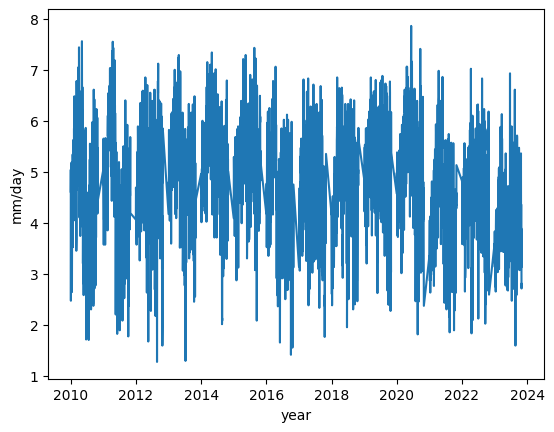

In [104]:
et1 = ETo()
et1.param_est(df= df_weather, freq='D', z_msl=10, lat=18.54, lon=-69.99, TZ_lon=-60.00, z_u=2, K_rs=0.16, a_s=0.25, b_s=0.5, alb=0.23)
et1.ts_param.head()
ETo_results = et1.eto_fao()
max_ETo = max(ETo_results)
print(f"the maximum ETo is {max_ETo} mm/day ")
min_ETo = min(ETo_results)
print(f"the minimum ETo is {min_ETo} mm/day ")
plt.plot(ETo_results)
plt.xlabel('year')
plt.ylabel('mm/day')



Text(0, 0.5, 'mm/day')

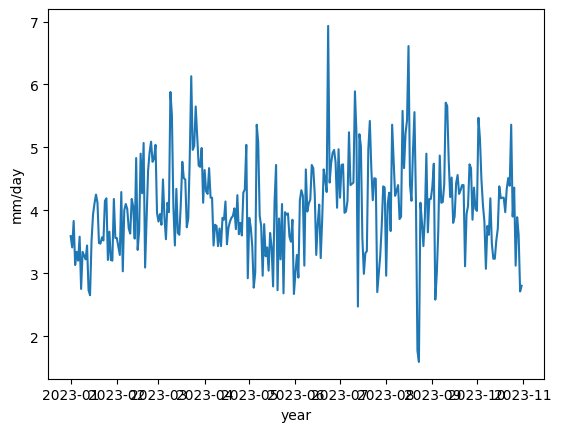

In [105]:
results_2023 = ETo_results['2023']
plt.plot(results_2023)
plt.xlabel('year')
plt.ylabel('mm/day')

In [119]:
#plantians 
kc_plantains = 0.88 #Goenaga et al (1995)
df_plantains = pd.DataFrame()
df_plantains['ETc_plantains'] = kc_plantains * ETo_results #mm/day
df_plantains['rainfall'] = df_precip_raw['precipitation.total'] #mm/day


df_plantains['effective_rainfall'] = np.where(df_plantains['rainfall'] > 2.5, (0.8/30) * df_plantains['rainfall'] - (25/30), (0.6/30) * df_plantains['rainfall'] - (10/30)) 
#from FAO section 4.4 (https://www.fao.org/3/s2022e/s2022e08.htm#4.2%20determination%20of%20the%20effective%20rainfall*) 
df_plantains['effective_rainfall'] = np.where(df_plantains['effective_rainfall'] < 0, 0, df_plantains['effective_rainfall']) #can never be less than zero 


df_plantains['irrigation need'] = df_plantains['ETc_plantains'] - df_plantains['effective_rainfall'] #mm/day
df_plantains['irrigation need'] = np.where(df_plantains['irrigation need'] < 0, 0, df_plantains['irrigation need']) #can never be less than zero 
# set to 0 if negative (https://extension.colostate.edu/topic-areas/agriculture/irrigation-scheduling-the-water-balance-approach-4-707/)

df_plantains

,ETc_plantains,rainfall,effective_rainfall,irrigation need
date,,,,
2010-01-01,4.0568,0.29,0.0,4.0568
2010-01-02,4.4352,0.99,0.0,4.4352
2010-01-03,2.1736,1.85,0.0,2.1736
2010-01-04,3.1856,1.53,0.0,3.1856
2010-01-05,4.3032,0.46,0.0,4.3032
...,...,...,...,...
2023-10-27,2.7456,0.00,0.0,2.7456
2023-10-28,3.4232,0.14,0.0,3.4232
2023-10-29,3.1768,2.44,0.0,3.1768


Text(0, 0.5, 'mm/day')

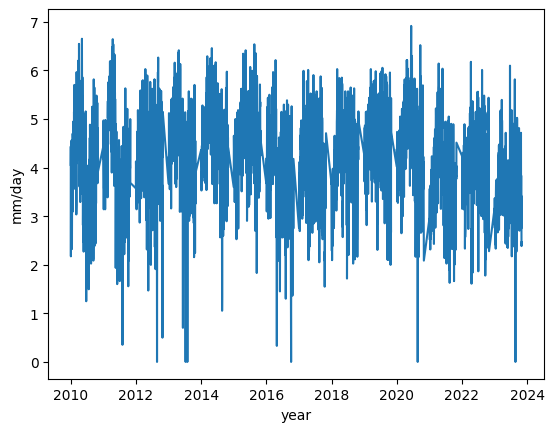

In [120]:
plt.plot(df_plantains['irrigation need'])
plt.xlabel('year')
plt.ylabel('mm/day')

{'bodies': [<matplotlib.collections.PolyCollection at 0x149edb150>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x15012e2d0>,
 'cmins': <matplotlib.collections.LineCollection at 0x149ee5d90>,
 'cbars': <matplotlib.collections.LineCollection at 0x15039efd0>}

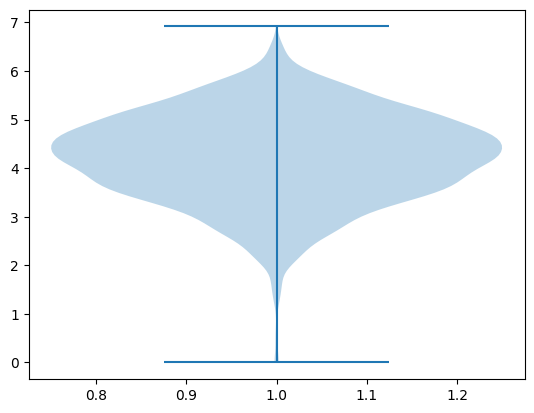

In [125]:
# box plot of irrigation need per day for plantains 
plt.violinplot(df_plantains['irrigation need'])


the maximum irrigation need for the plot is 1.5370666666666668 m3/day or 6.9168 mm/plant/day 
the run time is 3.842666666666667 hours 


Text(0.5, 1.0, 'total plot irrigation need for plantains')

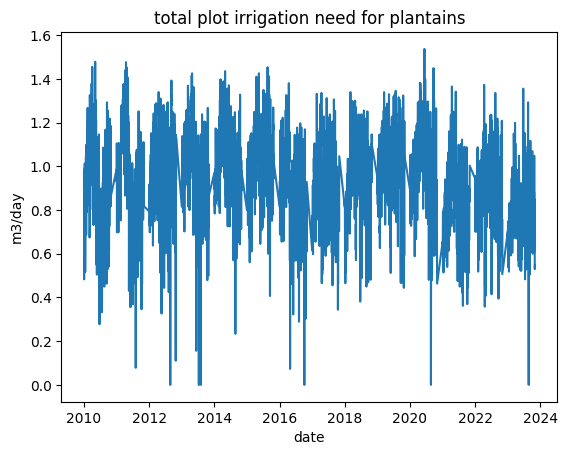

In [135]:
max_irrigation_plantains = max(df_plantains['irrigation need'])
eff_drip = 0.9 #drip irrigation efficiency 
L_plantain = 2 #m, distance between plantains 
n_plantains = (100/2) * 4 #number of plantains per plot (100 meter long rows with 4 rows per plot)

df_plantains['total irrigation need'] = (n_plantains * df_plantains['irrigation need']) / (eff_drip * 1000) #m3/day
V_max = max(df_plantains['total irrigation need'])
print(f"the maximum irrigation need for the plot is {V_max} m3/day or {max_irrigation_plantains} mm/plant/day ")

#if running at nominal flow rate 
t_run = ((V_max/n_plantains) * 1000) /2 #hours 
print(f"the run time is {t_run} hours ")

plt.plot(df_plantains['total irrigation need'])
plt.xlabel('date')
plt.ylabel('m3/day')
plt.title('total plot irrigation need for plantains')

In [ ]:
#re download weather sql (for full 2023 data)
#Consider Constanza for tomatoes and eggplants 


